In [ ]:
from google.colab import drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## OVERVIEW
---
* Image Preprocessing with OpenCV
    * Masking
    * Segmentation
    * Image Sharpening
* Transfer Learning with Keras Pretrained Model
* Feature Extraction
* Deep Learning Model to Classify the Images

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import cv2
from scipy.stats import uniform 
from tqdm import tqdm
from glob import glob
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
import keras.utils #import np_utils, to_categorical
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
!cp /content/drive/MyDrive/miniproj2/Keras/xception* ~/.keras/models/ #type:ignore
#show
!ls ~/.keras/models

xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
base_folder = '/content/drive/MyDrive/miniproj2/Fire dataset'
data_folder = '/content/drive/MyDrive/miniproj2/Fire dataset/fire_dataset'
train_data_folder = '/content/drive/MyDrive/miniproj2/Fire dataset/fire_dataset/fire_images'
test_date_folder  = '/content/drive/MyDrive/miniproj2/Fire dataset/fire_dataset/non_fire_images'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [ ]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:04,  2.05s/it]


In [ ]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))
for i in train_data:
    print(i)

fire_images -> 755
non_fire_images -> 244
['fire_images/fire.109.png', 0, 'fire_images']
['fire_images/fire.102.png', 0, 'fire_images']
['fire_images/fire.106.png', 0, 'fire_images']
['fire_images/fire.100.png', 0, 'fire_images']
['fire_images/fire.107.png', 0, 'fire_images']
['fire_images/fire.10.png', 0, 'fire_images']
['fire_images/fire.104.png', 0, 'fire_images']
['fire_images/fire.105.png', 0, 'fire_images']
['fire_images/fire.101.png', 0, 'fire_images']
['fire_images/fire.108.png', 0, 'fire_images']
['fire_images/fire.1.png', 0, 'fire_images']
['fire_images/fire.103.png', 0, 'fire_images']
['fire_images/fire.129.png', 0, 'fire_images']
['fire_images/fire.113.png', 0, 'fire_images']
['fire_images/fire.127.png', 0, 'fire_images']
['fire_images/fire.111.png', 0, 'fire_images']
['fire_images/fire.110.png', 0, 'fire_images']
['fire_images/fire.120.png', 0, 'fire_images']
['fire_images/fire.123.png', 0, 'fire_images']
['fire_images/fire.112.png', 0, 'fire_images']
['fire_images/fire.11

In [ ]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.109.png,0,fire_images
1,fire_images/fire.102.png,0,fire_images
2,fire_images/fire.106.png,0,fire_images
3,fire_images/fire.100.png,0,fire_images
4,fire_images/fire.107.png,0,fire_images


### IMAGE PREPROCESSING

In [ ]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask
    
#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

### SHOW SAMPLE IMAGES

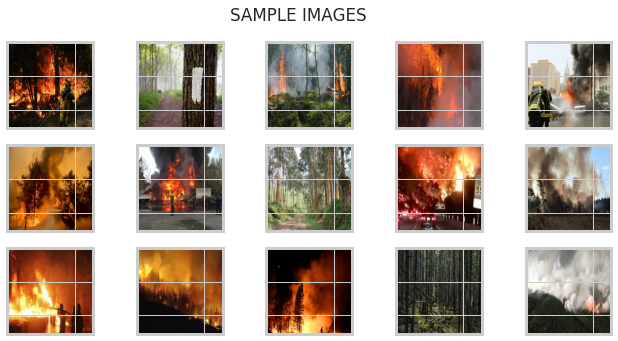

In [ ]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

### SHOW SAMPLE PROCESSED IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


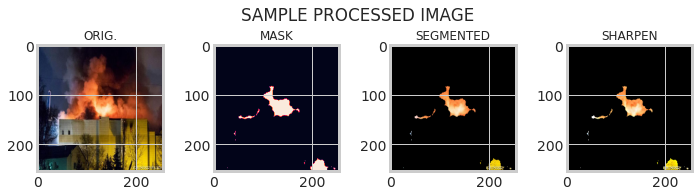

In [ ]:
#get an image
img = read_img(df['file'][101],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);



### XCEPTION BOTTLENECK FEATURE EXTRACTION

In [ ]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

999it [01:44,  9.60it/s]


In [ ]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (999, 255, 255, 3)
Train Image Size:  194879925


#### SPLIT THE DATA

In [ ]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [ ]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])
print('FIRE IMAGES ON Testing DATA: ',y_val[y_val==0].shape[0])
print('NON-FIRE IMAGES ON Testing DATA: ',y_val[y_val==1].shape[0])


FIRE IMAGES ON TRAINING DATA:  610
NON-FIRE IMAGES ON TRAINING DATA:  189
FIRE IMAGES ON Testing DATA:  145
NON-FIRE IMAGES ON Testing DATA:  55


In [ ]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)
xception_bf.summary()

7/7 [==============================] - 40s 6s/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)     

In [ ]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (799, 2048)
Train Size:  1636352
Validation Shape:  (200, 2048)
Validation Size:  409600


### DEEP LEARNING MODEL

In [ ]:
#keras Sequential model
model = Sequential()
#model.add(xception_bf)
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

Epoch 1/100
25/25 [==============================] - 1s 4ms/step - loss: 0.5443 - accuracy: 0.7635
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4765 - accuracy: 0.7635
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.4204 - accuracy: 0.7922
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.3971 - accuracy: 0.8160
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.3546 - accuracy: 0.8398
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.3349 - accuracy: 0.8511
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3223 - accuracy: 0.8573
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.2918 - accuracy: 0.8761
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 0.2865 - accuracy: 0.8673
Epoch 10/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3203 - accuracy: 0.8448
Epoch 11/

#### LOSS AND ACCURACY

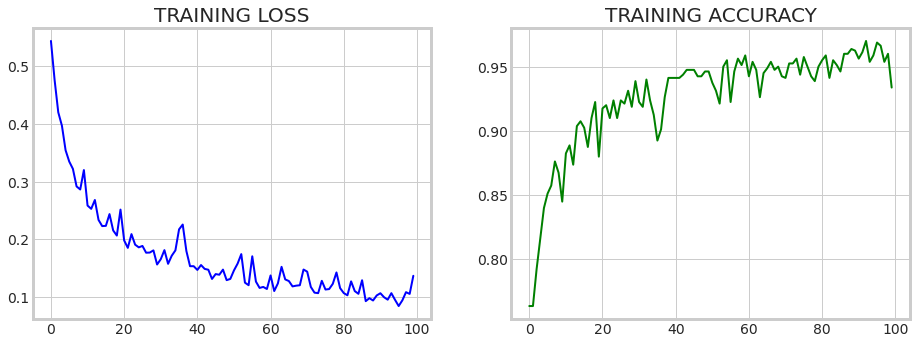

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'blue',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [ ]:
#predict the validation data
predictions =(model.predict(bf_train_val) > 0.5).astype("int32")

#### CLASSIFICATION REPORT

In [ ]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       145
           1       0.70      0.96      0.81        55

    accuracy                           0.88       200
   macro avg       0.84      0.90      0.86       200
weighted avg       0.91      0.88      0.88       200



#### CONFUSION MATRIX

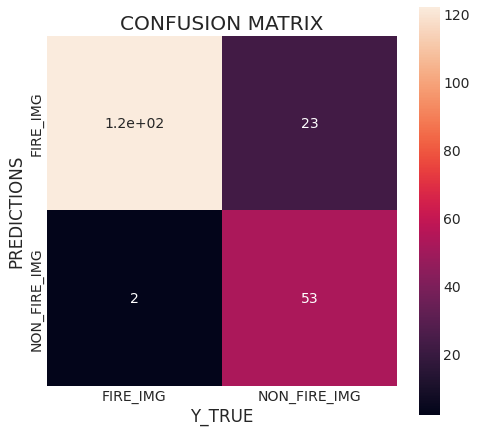

In [ ]:
confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(7,7))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");